In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

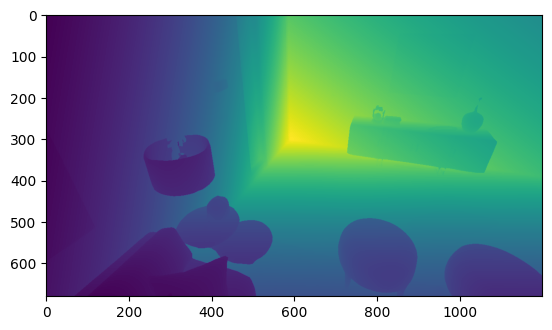

In [3]:
depth_orgin = cv2.imread("/home/zhuoran/data/room_0/imap/00/depth/depth_0.png", -1)

plt.imshow(depth_orgin)
plt.show()

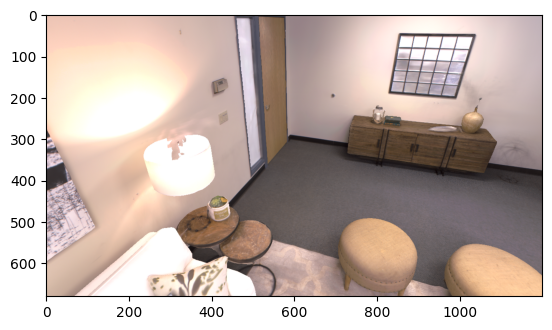

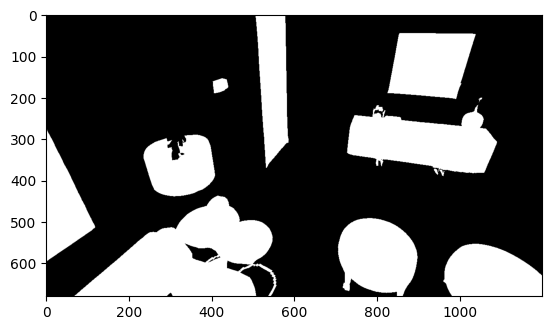

[  0 255]


In [4]:
bg = cv2.imread("/home/zhuoran/CS5478_proj/segmented/0/bg.png")
bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)

bg_mask = cv2.imread("/home/zhuoran/CS5478_proj/segmented/0/bg_mask.png")
bg_mask = cv2.cvtColor(bg_mask, cv2.COLOR_BGR2GRAY)

depth = cv2.imread("/home/zhuoran/data/room_0/imap/00/depth/depth_0.png", -1)
depth = depth.astype(np.int16)
plt.imshow(bg)
plt.show()

plt.imshow(bg_mask, cmap='gray')
plt.show()

print(np.unique(bg_mask))

In [30]:
offset = 10
def fill(arr: np.array, mask: np.array, rgb: np.array):
  if all(mask == 0) or all(mask == 255):
    return arr, mask, rgb
  segments = []
  prev = 0
  for i, m in enumerate(mask):
    if prev == 0 and m == 255:
      segments.append([i])
    if m == 0 and prev == 255:
      segments[-1].append(i)
    prev = m
  if len(segments[-1]) == 1:
    segments[-1].append(len(mask) - 1)
    
  last_r_idx = -1
  for seg_idx, seg in enumerate(segments):
    assert len(seg) == 2
    sta, end = seg
    if sta == 0 or seg == len(mask) - 1:
      continue
    
    l_idx = sta - offset
    l_idx = max(l_idx, last_r_idx + 1)
    last_r_idx = end
    
    r_idx = end + offset
    next_l_idx = len(mask)
    if seg_idx < len(segments) - 1:
      next_l_idx = segments[seg_idx + 1][0]
    r_idx = min(r_idx, next_l_idx - 1)
    
    left = arr[l_idx: sta - 1]
    right = arr[end + 1: r_idx]
    
    left_rgb = rgb[l_idx: sta - 1]
    right_rgb = rgb[end + 1: r_idx]
    
    if len(left) < 2 or len(right) < 2:
      continue
    
    to_fill_left = np.arange(1.0, end - sta + 2)
    to_fill_right = np.arange(end - sta + 1, 0.0, -1)
    
    to_fill_left_rgb = np.mean(left_rgb, axis=0)
    to_fill_right_rgb = np.mean(right_rgb, axis=0)
    
    left_diff = (left[-1] - left[0]) / (len(left) - 1)
    right_diff = (right[0] - right[-1]) / (len(right) - 1)
    # print(f'{left[-1]} - {left[0]} / ({len(left) - 1})')
    # print(f'{right[0]} - {right[-1]} / ({len(right) - 1})')
    
    to_fill_left *= left_diff
    to_fill_left += left[-1]
    
    to_fill_right *= right_diff
    to_fill_right += right[0]

    diff = np.abs(to_fill_left - to_fill_right)
    diff_idx = np.argmin(diff)
    
    to_fill = np.zeros(end - sta + 1)
    to_fill_rgb = np.zeros((end - sta + 1, 3))
    
    to_fill[:diff_idx] = to_fill_left[:diff_idx]
    to_fill[diff_idx:] = to_fill_right[diff_idx:]
    
    to_fill_rgb[:diff_idx] = to_fill_left_rgb
    to_fill_rgb[diff_idx:] = to_fill_right_rgb
    
    arr[sta: end + 1] = to_fill
    mask[sta: end + 1] = 0
    rgb[sta: end + 1] = to_fill_rgb

  return arr, mask, rgb

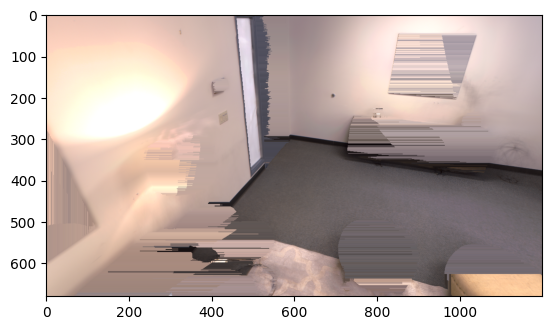

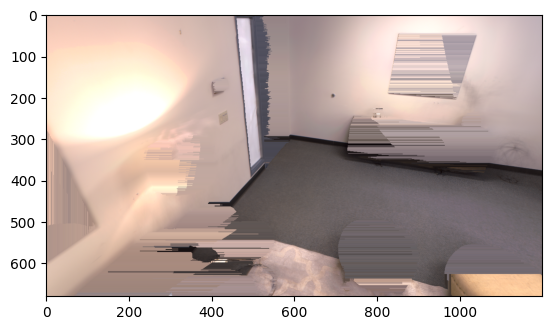

In [36]:
w,h,c =(bg.shape)
from copy import deepcopy as dc
depth_h = dc(depth)
depth_w = dc(depth)

bgm_h = dc(bg_mask)
bgm_w = dc(bg_mask)

for i in range(w):
  _depth, _bg_mask, _bg = fill(depth[i], bg_mask[i], bg[i])
  depth_h[i] = _depth
  bgm_h[i] = _bg_mask
  bg[i] = _bg

for i in range(h):
  _depth, _bg_mask, _bg = fill(depth[:, i], bg_mask[:, i], bg[:, i])
  depth_w[:, i] = _depth
  bgm_w[:, i] = _bg_mask
  bg[:, i] = _bg
  
depth = (depth_w + depth_h) / 2
bg_mask = (bgm_h & bgm_w)

In [32]:
np.unique(depth)

array([1174. , 1174.5, 1175. , ..., 5005. , 5006. , 5007. ])

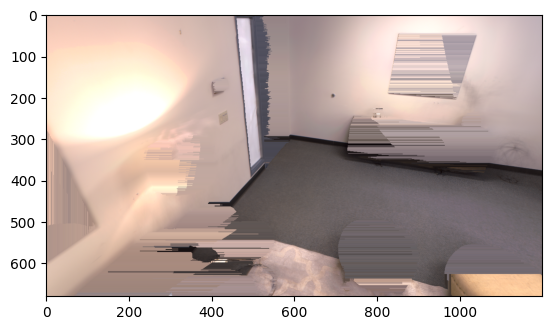

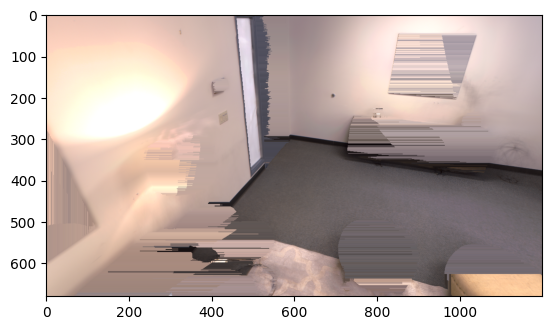

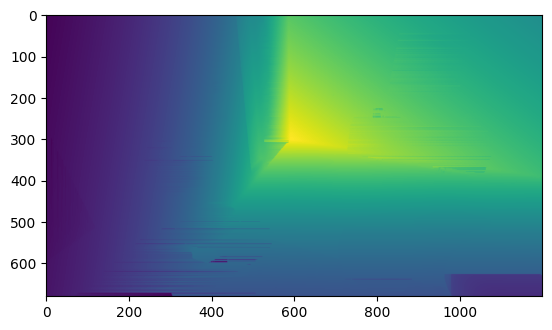

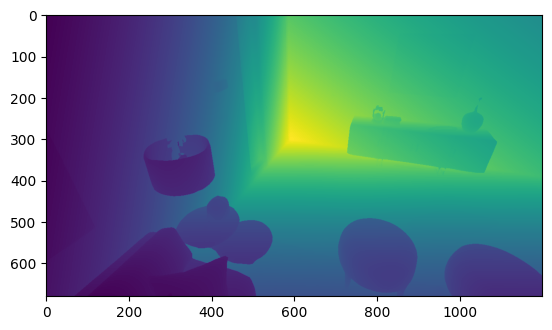

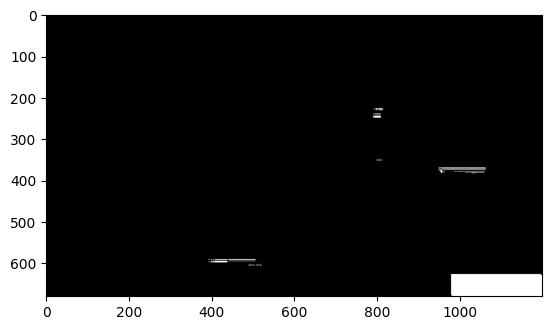

In [35]:
plt.imshow(bg)
plt.show()

blur = cv2.GaussianBlur(bg,(5,5),0)
plt.imshow(bg)
plt.show()

plt.imshow(depth)
plt.show()
plt.imshow(depth_orgin)
plt.show()
plt.imshow(bg_mask, cmap='gray')

In [34]:
bgm_h 

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)